In [ ]:
import math
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# as self attention we will use seq length of 4
seq_length = 4
batch_size = 1
input_dim = 512
d_model = 512  # d_model represents the output length
x = torch.randn( (batch_size, seq_length, input_dim) )

In [ ]:
x.size()

torch.Size([1, 4, 512])

In [ ]:
qkv_layer = nn.Linear(input_dim, 3*d_model)
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

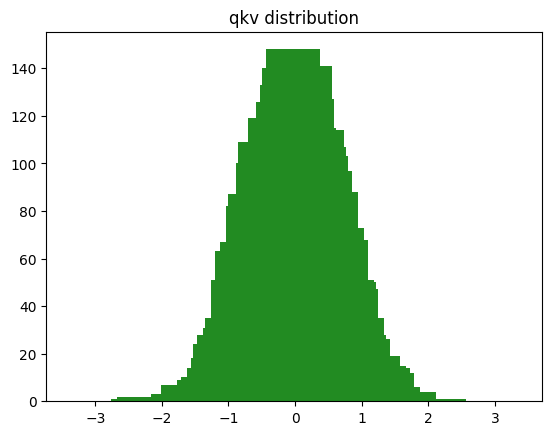

In [ ]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [ ]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, seq_length, num_heads, 3*head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [ ]:
qkv = qkv.permute(0,2,1,3)

In [ ]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

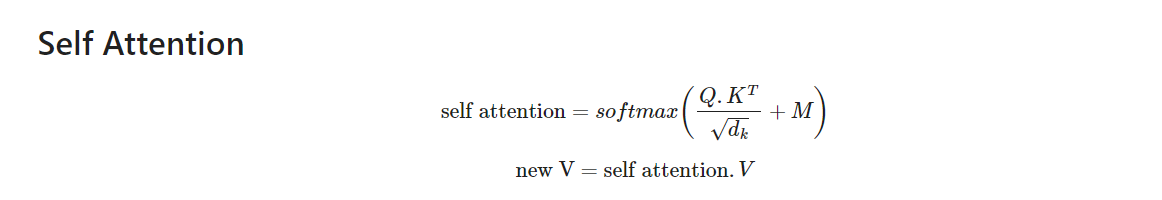

In [ ]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [ ]:
mask = torch.full(scaled.size(), float('-inf')) # create tensor with size of [1,8,4,4] with all values = -inf
mask = torch.triu(mask, diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [ ]:
(scaled + mask)[0][0]

tensor([[ 0.0758,    -inf,    -inf,    -inf],
        [ 0.2307, -0.3961,    -inf,    -inf],
        [ 0.1851, -0.0171,  0.1339,    -inf],
        [-0.0285, -0.1107, -0.0923, -0.0331]], grad_fn=<SelectBackward0>)

In [ ]:
scaled += mask

In [ ]:
attention = F.softmax(scaled, dim=-1)
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6518, 0.3482, 0.0000, 0.0000],
        [0.3614, 0.2952, 0.3434, 0.0000],
        [0.2594, 0.2389, 0.2434, 0.2582]], grad_fn=<SelectBackward0>)

In [ ]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [ ]:
def scaled_dot_product(q, k, v, mask=None) :

  d_k = q.size()[-1]
  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
  if mask is not None :
    scaled += mask
  attention = F.softmax(scaled, dim=-1)
  values = torch.matmul(attention, v)

  return values, attention

In [ ]:
values, attention = scaled_dot_product(q, k, v, mask=mask)
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6518, 0.3482, 0.0000, 0.0000],
        [0.3614, 0.2952, 0.3434, 0.0000],
        [0.2594, 0.2389, 0.2434, 0.2582]], grad_fn=<SelectBackward0>)

In [ ]:
values.size()

torch.Size([1, 8, 4, 64])

In [ ]:
values = values.reshape(batch_size, seq_length, num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [ ]:
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

In [ ]:
out

tensor([[[-0.2337, -0.1213, -0.0041,  ..., -0.2516, -0.1431,  0.5111],
         [ 0.2308,  0.3425,  0.4011,  ..., -0.0960, -0.3513, -0.0239],
         [ 0.2081,  0.0295,  0.1811,  ...,  0.0401,  0.0182, -0.0527],
         [ 0.2984, -0.0356, -0.0508,  ..., -0.2771, -0.1646, -0.0415]]],
       grad_fn=<ViewBackward0>)

## The following 2 cells is the whole architecture of Multi head attention:

In [6]:
import numpy 
import math
import torch 
import torch.nn as nn
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None) :

  d_k = q.size()[-1]
  scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
  if mask is not None :
    scaled += mask
  attention = F.softmax(scaled)
  values = torch.matmul(attention, v)
  return values, attention


class Multiheadattention(nn.Module):


  def __init__(self, input_dim, d_model, num_heads) :

    super().__init__()
    self.input_dim = input_dim
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(input_dim, d_model*3)
    self.linear_layer = nn.Linear(d_model, d_model)

  def forward(self, x, mask=None) :

    batch_size, seq_length, input_dim = x.size()
    print(f"x.size() : {x.size()}")
    qkv = self.qkv_layer(x)
    print(f"qkv.size() : {qkv.size()}")
    qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
    print(f"qkv.size(): {qkv.size()}")
    qkv = qkv.permute(0, 2, 1,3)
    print(f"qkv.size() : {qkv.size()}")
    q, k, v = qkv.chunk(3, dim=-1)
    print(f"q.size() : {q.size()}, k.size() : {k.size()}, v.size() : {v.size()}")
    values, attention = scaled_dot_product(q, k, v, mask)
    print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
    values = values.reshape(batch_size, seq_length, self.num_heads*self.head_dim)
    print(f"values.size(): {values.size()}")
    out = self.linear_layer(values)
    print(f"out.size(): {out.size()}")

    return out


In [7]:
batch_size = 30
input_dim = 1024
d_model = 512
num_heads = 8
seq_length = 5

x = torch.randn( (batch_size, seq_length, input_dim) )
model = Multiheadattention(input_dim, d_model, num_heads)

out = model.forward(x)

x.size() : torch.Size([30, 5, 1024])
qkv.size() : torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size() : torch.Size([30, 8, 5, 192])
q.size() : torch.Size([30, 8, 5, 64]), k.size() : torch.Size([30, 8, 5, 64]), v.size() : torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


<ipython-input-6-b8e38243f809>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(scaled)


In [1]:
import torch